In [1]:
# Simulate a function

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Data generation
# non-linear function y = sin(x) (1000 points from 0 to 2pi)
x_values = np.linspace(0, 2 * np.pi, 1000)
y_values = np.sin(x_values)
print(f"x_values.shape: {x_values.shape}")
print(f"y_values.shape: {y_values.shape}")

x_values.shape: (1000,)
y_values.shape: (1000,)


In [6]:
# Convert numpy arrays to PyTorch tensors
x_train = torch.tensor(x_values, dtype=torch.float32).view(-1, 1).to(device)
y_train = torch.tensor(y_values, dtype=torch.float32).view(-1, 1).to(device)
print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")

x_train.shape: torch.Size([1000, 1])
y_train.shape: torch.Size([1000, 1])


In [7]:
# Hyperparameters
input_size = 1
output_size = 1
num_epochs = 20000
learning_rate = 0.001

In [8]:
# Shallow model
class ShallowModel(nn.Module):
    def __init__(self):
        super(ShallowModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 115)
        self.fc2 = nn.Linear(115, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Deep model: three hidden layers
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 5)
        self.fc4 = nn.Linear(5, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [10]:
# Initialize models
shallow_model = ShallowModel().to(device)
deep_model = DeepModel().to(device)

In [11]:
print(shallow_model.parameters)
# total_params = sum(p.numel() for p in shallow_model.parameters())
shallow_total_params = sum(p.numel() for p in shallow_model.parameters() if p.requires_grad)
print(shallow_total_params)

print(deep_model.parameters)
deep_total_params = sum(p.numel() for p in deep_model.parameters() if p.requires_grad)
print(deep_total_params)

<bound method Module.parameters of ShallowModel(
  (fc1): Linear(in_features=1, out_features=115, bias=True)
  (fc2): Linear(in_features=115, out_features=1, bias=True)
)>
346
<bound method Module.parameters of DeepModel(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)>
351


In [12]:
# lr and optimizer for each model initialized seperately; same loss functions for both models
criterion = nn.MSELoss()
optimizer_shallow = optim.Adam(shallow_model.parameters(), lr=learning_rate)
optimizer_deep = optim.Adam(deep_model.parameters(), lr=learning_rate)

In [13]:
# Training function
def train(model, optimizer, num_epochs):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        # Forward pass
        output = model(x_train)
        loss = criterion(output, y_train)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # add loss for each epoch to the loss list
        loss_list.append(loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    return loss_list

In [14]:
# Train both models
print("Training Shallow Model...")
shallow_loss = train(shallow_model, optimizer_shallow, num_epochs)
print("Training Deep Model...")
deep_loss = train(deep_model, optimizer_deep, num_epochs)

Training Shallow Model...
Epoch [10/20000], Loss: 0.4008
Epoch [20/20000], Loss: 0.3103
Epoch [30/20000], Loss: 0.2608
Epoch [40/20000], Loss: 0.2276
Epoch [50/20000], Loss: 0.2023
Epoch [60/20000], Loss: 0.1821
Epoch [70/20000], Loss: 0.1678
Epoch [80/20000], Loss: 0.1559
Epoch [90/20000], Loss: 0.1462
Epoch [100/20000], Loss: 0.1379
Epoch [110/20000], Loss: 0.1308
Epoch [120/20000], Loss: 0.1247
Epoch [130/20000], Loss: 0.1196
Epoch [140/20000], Loss: 0.1156
Epoch [150/20000], Loss: 0.1122
Epoch [160/20000], Loss: 0.1092
Epoch [170/20000], Loss: 0.1067
Epoch [180/20000], Loss: 0.1044
Epoch [190/20000], Loss: 0.1024
Epoch [200/20000], Loss: 0.1005
Epoch [210/20000], Loss: 0.0986
Epoch [220/20000], Loss: 0.0968
Epoch [230/20000], Loss: 0.0949
Epoch [240/20000], Loss: 0.0931
Epoch [250/20000], Loss: 0.0912
Epoch [260/20000], Loss: 0.0892
Epoch [270/20000], Loss: 0.0873
Epoch [280/20000], Loss: 0.0853
Epoch [290/20000], Loss: 0.0833
Epoch [300/20000], Loss: 0.0814
Epoch [310/20000], Loss

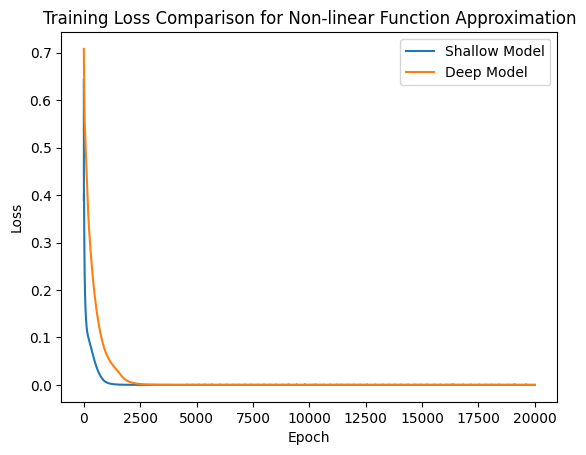

In [15]:
# Plot the training loss for both models
plt.figure()
plt.plot(shallow_loss, label='Shallow Model')
plt.plot(deep_loss, label='Deep Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison for Non-linear Function Approximation')
plt.legend()
plt.show()

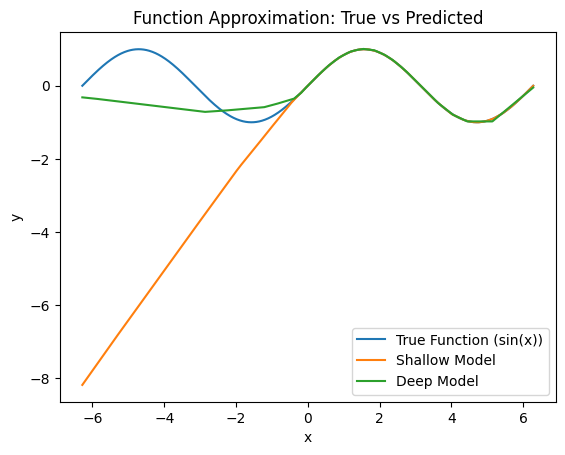

In [19]:
# Plot the predicted functions against the true function
x_test = torch.tensor(np.linspace(-2 * np.pi, 2 * np.pi, 1000), dtype=torch.float32).view(-1, 1).to(device)
y_true = np.sin(x_test.cpu().numpy())

y_pred_shallow = shallow_model(x_test).cpu().detach().numpy()
y_pred_deep = deep_model(x_test).cpu().detach().numpy()

plt.figure()
plt.plot(x_test.cpu().numpy(), y_true, label='True Function (sin(x))')
plt.plot(x_test.cpu().numpy(), y_pred_shallow, label='Shallow Model')
plt.plot(x_test.cpu().numpy(), y_pred_deep, label='Deep Model')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Approximation: True vs Predicted')
plt.legend()
plt.show()